In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import string
import warnings
import missingno
warnings.filterwarnings('ignore')

In [2]:
df_test = pd.read_csv('/Users/miji.lee/Desktop/ML Practice/bike_sharing/test.csv')
df_train = pd.read_csv('/Users/miji.lee/Desktop/ML Practice/bike_sharing/train.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop= True)
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [4]:
df_train.shape

(10886, 12)

In [ ]:
df_test.shape

# 만약 합쳐진 상태에서 test, train으로 나누려면
# df_train = df_all[:10885]
# df_test = df_all[10886:]
# 혹은
# def split_df(df):
#     return df[:10885], df[10886:]

(6493, 9)

In [ ]:
# datatime 컬럼 일자로 바꿔주기
df_train['datetime'] = pd.to_datetime(df_train['datetime'], format = '%Y-%m-%d %H:%M:%S', errors = 'raise') # format: 현재 타입은 무엇임을 인지시키기. errors: 에러나면 멈추기
df_train.groupby(pd.Grouper(key = 'datetime', freq= 'D')).mean().head() # 날짜별로 평균 내기 

# grouper: 단순 groupby('컬럼')보다 더 복잡한 기준을 적용할 수 있음
# 멀티인덱스, 시간인덱스, 시간 데이터를 월별, 분기별, 연별 등으로 쉽게 묶을 수 있음
# freq = 'D' : day 날짜별로그루핑

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_timestamp
datetime,,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,1.583333,14.110833,18.181250,80.583333,10.749871,13.791667,27.250000,41.041667,2011-01-01 11:30:00.000000000
2011-01-02,1.0,0.0,0.0,1.956522,14.902609,17.686957,69.608696,16.652122,5.695652,29.130435,34.826087,2011-01-02 11:46:57.391304448
2011-01-03,1.0,0.0,1.0,1.000000,8.050909,9.470227,43.727273,16.636709,5.454545,55.863636,61.318182,2011-01-03 12:19:05.454545408
2011-01-04,1.0,0.0,1.0,1.043478,8.200000,10.606087,59.043478,10.739809,4.695652,63.217391,67.913043,2011-01-04 11:52:10.434782720
2011-01-05,1.0,0.0,1.0,1.000000,9.305217,11.463478,43.695652,12.522300,3.565217,66.000000,69.565217,2011-01-05 11:52:10.434782720


In [ ]:
df_train['datetime_timestamp'] = pd.to_datetime(df_train['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_train['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()
# .dt: datetime관련 메서드/속성을 매 줄마다 적용 (.str같이)
# .strftime(format): 날짜/시간을 원하는 형식의 '문자열'로 반환

array(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
       '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
       '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
       '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16',
       '2011-01-17', '2011-01-18', '2011-01-19', '2011-02-01',
       '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
       '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09',
       '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13',
       '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17',
       '2011-02-18', '2011-02-19', '2011-03-01', '2011-03-02',
       '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06',
       '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10',
       '2011-03-11', '2011-03-12', '2011-03-13', '2011-03-14',
       '2011-03-15', '2011-03-16', '2011-03-17', '2011-03-18',
       '2011-03-19', '2011-04-01', '2011-04-02', '2011-04-03',
       '2011-04-04', '2011-04-05', '2011-04-06', '2011-

In [4]:
df_test['datetime_timestamp'] = pd.to_datetime(df_test['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_test['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()

array(['2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23',
       '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
       '2011-01-28', '2011-01-29', '2011-01-30', '2011-01-31',
       '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23',
       '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27',
       '2011-02-28', '2011-03-20', '2011-03-21', '2011-03-22',
       '2011-03-23', '2011-03-24', '2011-03-25', '2011-03-26',
       '2011-03-27', '2011-03-28', '2011-03-29', '2011-03-30',
       '2011-03-31', '2011-04-20', '2011-04-21', '2011-04-22',
       '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26',
       '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30',
       '2011-05-20', '2011-05-21', '2011-05-22', '2011-05-23',
       '2011-05-24', '2011-05-25', '2011-05-26', '2011-05-27',
       '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31',
       '2011-06-20', '2011-06-21', '2011-06-22', '2011-06-23',
       '2011-06-24', '2011-06-25', '2011-06-26', '2011-

<Axes: >

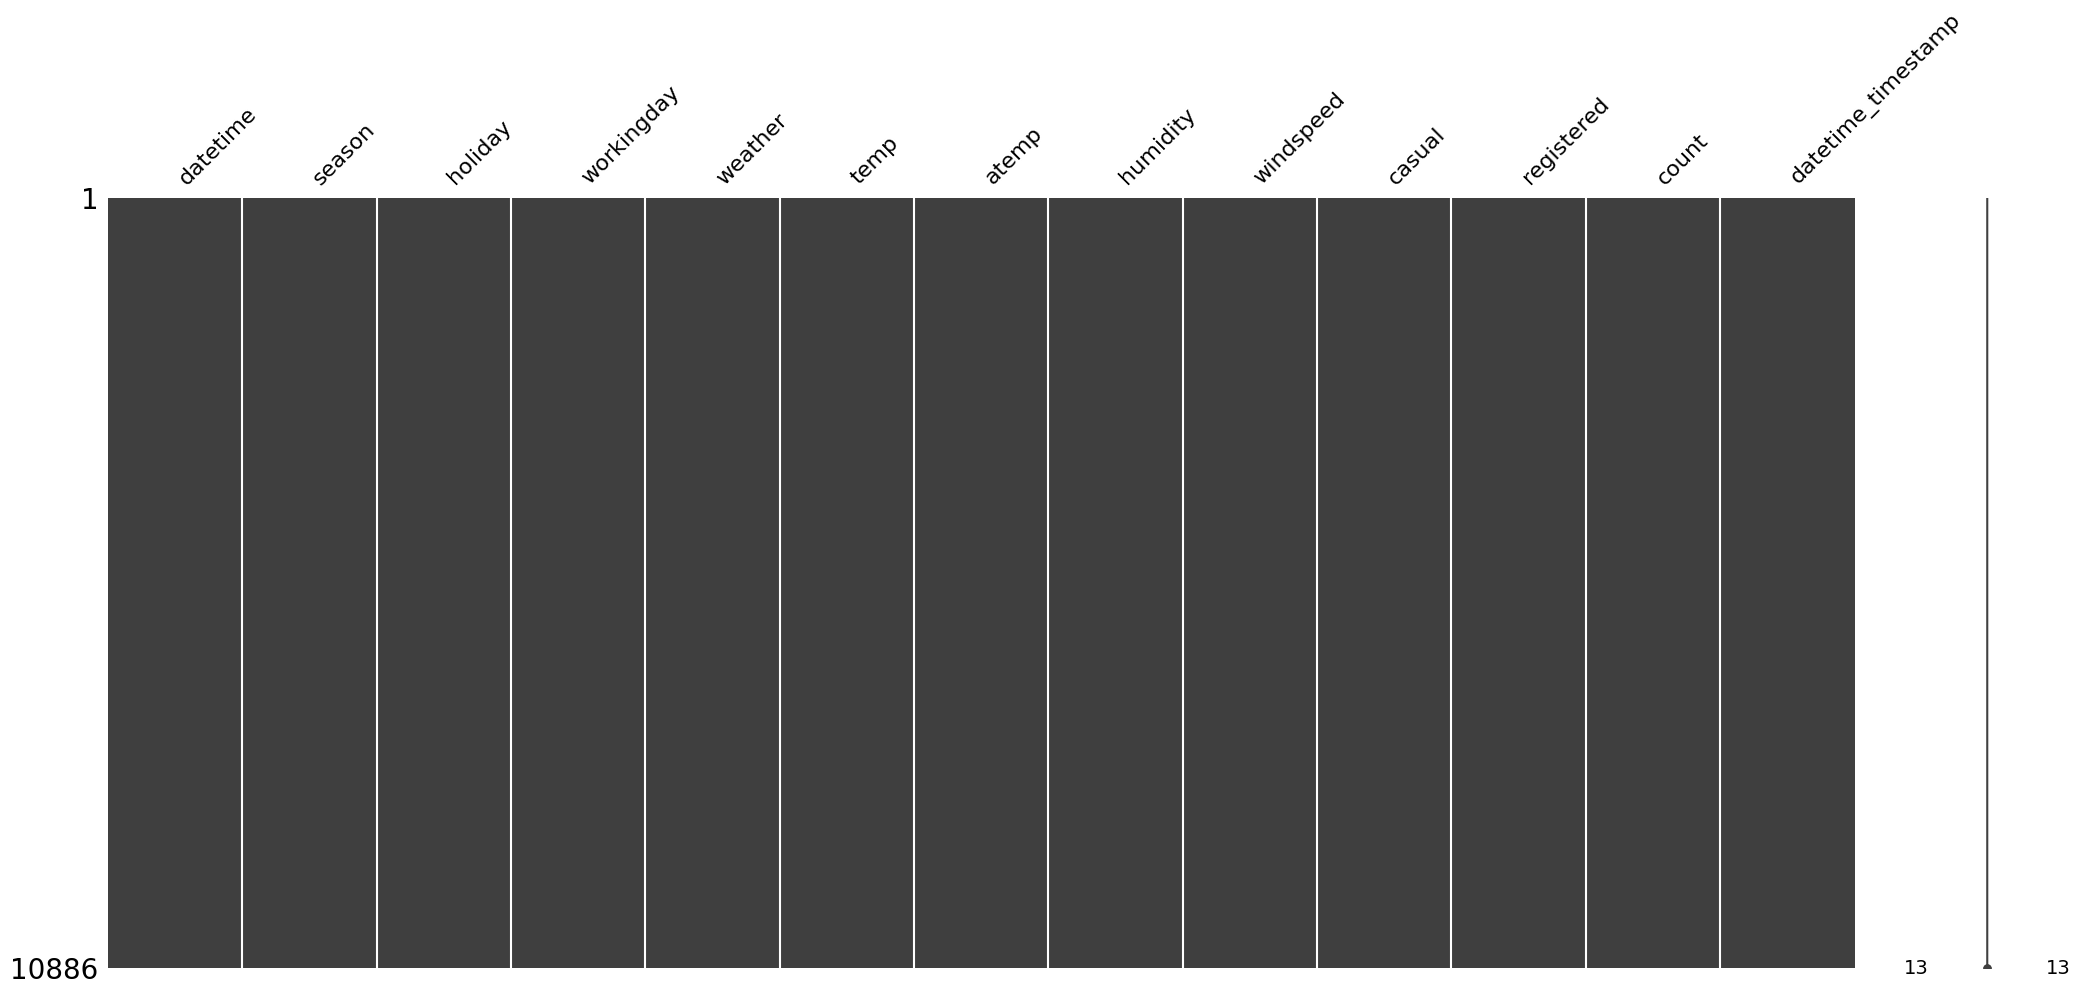

In [ ]:
missingno.matrix(df_train) # 결측치 없음

<Axes: >

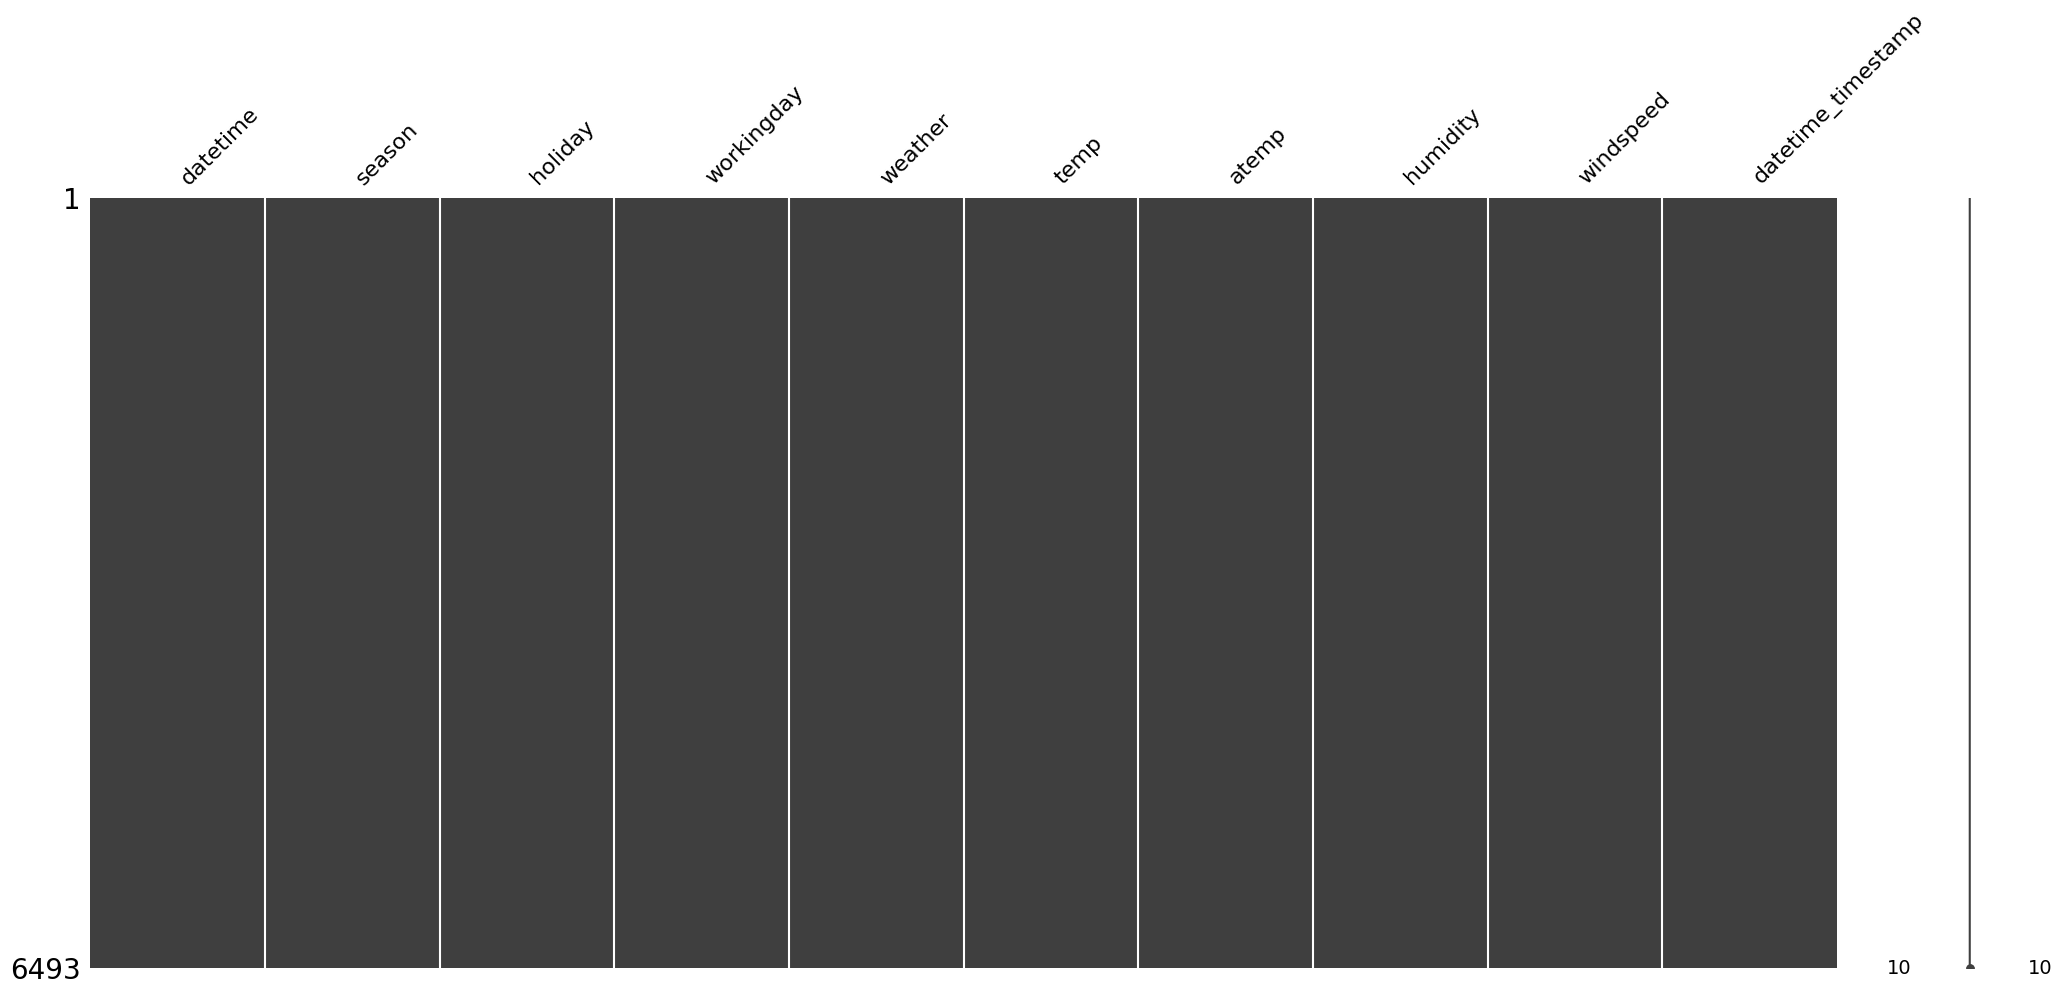

In [6]:
missingno.matrix(df_test)

In [ ]:
dt = pd.DatetimeIndex(df_all['datetime'])
dt

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17379, freq=None)

In [ ]:
dt = pd.DatetimeIndex(df_all['datetime']) # 인덱스 전용 객체. 시간 인덱스 정보만 담고 있음.
df_all.set_index(dt, inplace = True) # df_all의 인덱스를 날짜로 바꾼다

df_all['date'] = dt.date
df_all['day'] = dt.day
df_all['month'] = dt.month
df_all['year'] = dt.year
df_all['hour'] = dt.hour
df_all['dow'] = dt.dayofweek
# df_all['woy'] = dt.weekofyear

In [10]:
df_all['casual_log'] = np.log(df_all['casual']+1)
df_all['registered_log'] = np.log(df_all['registered']+1)
df_all['count_log'] = np.log(df_all['count']+1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_train, df_test = split_df(df_all)
def visualise(column_name):
    df_train_workingday_time = df_train.groupby(['workingday', column_name]).sum()
    df_train_workingday_time = df_train_workingday_time.reset_index()
    
    times_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday']==0][column_name]
    counts_nonworkday - df_train_workingday_time[df_train_workingday_time['workingday']==0][column_name]
    
    times_workday = df_train_workingday_time[df_train_workingday_time['workingday']==1][column_name]
    counts_workday - df_train_workingday_time[df_train_workingday_time['workingday']==1][column_name]
    
    df_temp_workday = pd.concat([times_workday, counts_workday], axis =1, keys = [column_name, 'count'])
    df_temp_nonworkday = pd.concat([times_nonworkday, counts_nonworkday], axis =1, keys = [column_name, 'count'])
    
    fig = make_subplots(rows = 1, cols = 2, subplot_titles=('workday', 'non-workday'))
    fig.add_trace(
        go.Bar(x=df_temp_workday[column_name], 
               y= df_temp_workday['count'],
               text = df_temp_workday['count'],
               textposition= ,
               row = 1,
               col = 1
               )
    )
    fig.add_trace(
        go.Bar(x = df_temp_nonworkday[column_name],
               y = df_temp_nonworkday['count'],
                text = df_temp_nonworkday['count'],
               textposition= auto,
               row = 1,
               col = 2
        )
        )
    fig.update_layout(showlegend = False)
    fig.show()


In [ ]:
visualise('dow')

In [ ]:
visualise('woy')

In [ ]:
visualise('hour')

In [ ]:
df_train, df_test = split_df(df_all)
df_train_workingday_hour = df_train.groupby(['workingday', 'hour']).sum()
df_train_workingday_hour = df_train_workingday_hour.reset_index()

hours_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday']==0]['hour']
counts_nonworkday - df_train_workingday_hour[df_train_workingday_hour['workingday']==0]['count']

hours_workday = df_train_workingday_hour[df_train_workingday_hour['workingday']==1]['hour']
counts_workday - df_train_workingday_hour[df_train_workingday_hour['workingday']==1]['count']

df_temp_workday = pd.concat([hours_workday, counts_workday], axis =1, keys = ['hour', 'count'])
df_temp_nonworkday = pd.concat([hours_nonworkday, counts_nonworkday], axis =1, keys = ['hour', 'count'])

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(x = df_temp_workday['hour'],
           y = df_temp_workday['count'],
           text = df_temp_workday['count'],
           textposition=auto,
           )
)
fig.update_layout({
    'title':{'text':"<b>workday<b>"},
    'xaxis':{'showticklabels':True, 'dtick':'1'},
    'template':'ggplot2'
})
fig.show()

fig = go.Figure()
fig.add_trace(
    go.Bar(x = df_temp_nonworkday['hour'],
           y = df_temp_nonworkday['count'],
           text = df_temp_nonworkday['count'],
           textposition=auto,
           )
)
fig.update_layout({
    'title':{'text':"<b>non-workday<b>"},
    'xaxis':{'showticklabels':True, 'dtick':'1'},
    'template':'seaborn'
})
fig.show()

In [ ]:
def func(df_data):
    if df_data['workingday']==1:
        if(df_data['hour']==8) or (df_data['hour']>=17 and df_data['hour']<=18):
            return 1
    else:
        if (df_data['hour']>=10 and df_data['hour']<=19):
            return 1
    return 0

df_all['peak'] = df_all.apply(func, axis =1)